In [1]:
#=====================================================
# Title:  basic tutorial on how to use toolkit.py
# Author: Divish Rengasamy
# Date:   30 - 04 - 2020
#=====================================================

import pandas as pd
import numpy as np
from sklearn.datasets import make_regression
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# toolkit
from toolkit import create_benchmark

%matplotlib inline

# Create a sample regression dataset

In [2]:
# create the inputs and outputs
X, y = make_regression(n_samples=1000, n_features=20, noise=0.2, n_targets = 1)

# reshape y
y = np.reshape(y, (-1,1))

# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# reshape y_train and y_test for tensorflow
y_train = np.reshape(y_train, (-1,1))
y_test = np.reshape(y_test, (-1,1))
print('Train', X_train.shape, y_train.shape, 'Test', X_test.shape, y_test.shape)


Train (800, 20) (800, 1) Test (200, 20) (200, 1)


# Custom Deep learning model

In [3]:
def base_model():
    model = tf.keras.Sequential([
    layers.Dense(64, activation='tanh', input_shape=(X_train.shape[1],),bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(64, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(32, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(16, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(8, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(6, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(4, activation='tanh',bias_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='linear')])

    radam = tfa.optimizers.RectifiedAdam()
    ranger = tfa.optimizers.Lookahead(radam, sync_period=6, slow_step_size=0.5)
    model.compile(optimizer=ranger,
                  loss='mse',       
                  metrics=['mae'])  

    return model

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=100, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True)

dnn_model = KerasRegressor(build_fn=base_model,
                          epochs=200,
                          batch_size=32,
                          verbose=0,
                          validation_split = 0.1) 

# Custom scorer (evaluation metrics)

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

custom_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Create Benchmark

  0%|          | 0/5 [00:00<?, ?it/s]

Running DNN...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


 20%|██        | 1/5 [00:40<02:41, 40.30s/it]

Running Linear Regression...
Running K Neighbors Regressor...
Running Random Forest...


100%|██████████| 5/5 [00:41<00:00,  8.39s/it]

Running Dummy Regressor...


,r2,max error,mean squared error,median absolute error,root mean squared error,mean absolute error,mape
DNN,0.0601±0.0065,526.7910±10.0843,28831.5166±627.2777,112.4644±2.1707,169.7884±1.8472,133.6480±1.1548,108.0258±4.8902
Linear Regression,1.0000±0.0000,0.6756±0.0091,0.0391±0.0014,0.1278±0.0018,0.1977±0.0035,0.1562±0.0021,0.3910±0.0153
K Neighbors Regressor,0.5930±0.0183,380.5584±58.2671,12475.1226±374.3349,75.2820±2.0922,111.6795±1.6759,88.6818±2.0074,183.8615±52.8665
Random Forest,0.7725±0.0127,299.1152±14.4653,6971.7770±284.5386,51.8296±1.4497,83.4798±1.7042,64.3089±1.3581,121.1845±5.6080
Dummy Regressor,0.0000±0.0000,524.4655±10.4846,30671.7292±456.5972,117.9059±0.2169,175.1286±1.3036,139.9291±0.3962,111.4218±6.4755


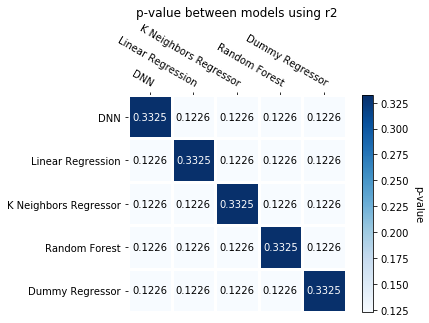

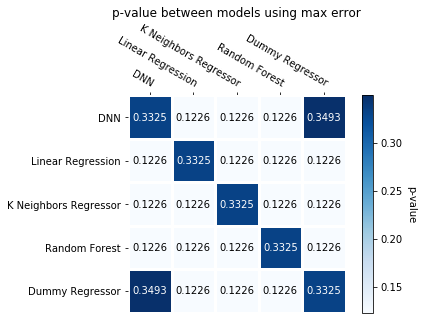

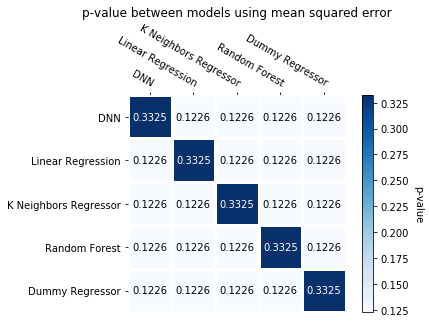

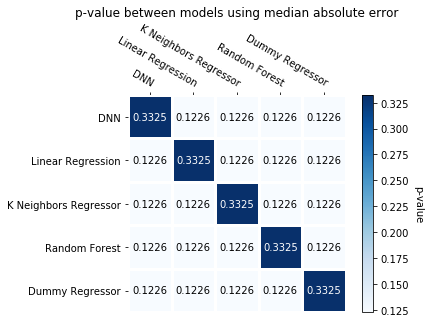

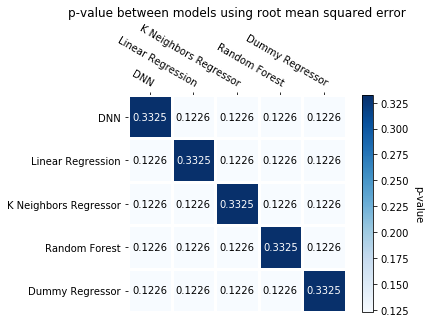

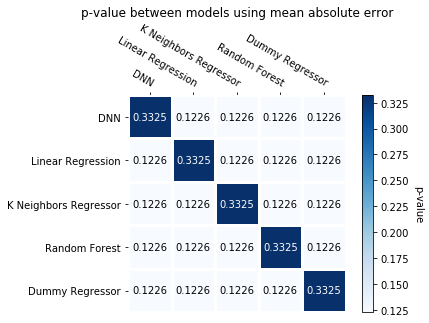

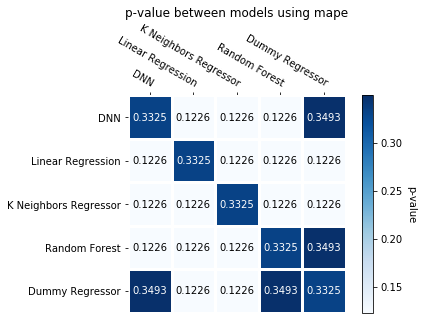

In [5]:
create_benchmark(X, y, new_model_list=[dnn_model], new_model_name_list=['DNN'], custom_scorer_list=[custom_scorer],
                 custom_scorer_name_list=['mape'], num_cv_fold=2)